In [103]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from xgboost import XGBClassifier, plot_importance

warnings.filterwarnings("ignore")

In [90]:
df= pd.read_csv("star_classification.csv")

In [91]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [93]:
df["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [94]:
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

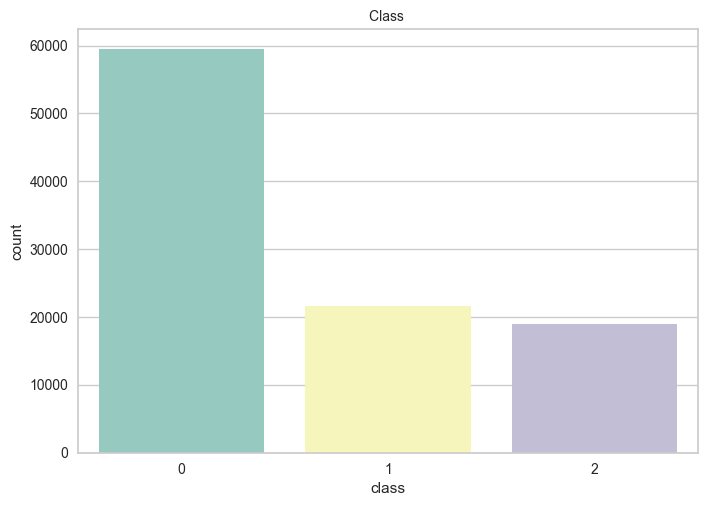

In [95]:
#count plot
sns.countplot(data=df, x='class', palette="Set3")
plt.title("Class ",fontsize=10)
plt.show()

In [96]:
#removing outliers
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df) 

In [97]:
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

#threshold
threshold2 = -1.5                                            
filtre2 = outlier_score["score"] < threshold2
outlier_index = outlier_score[filtre2].index.tolist()

In [98]:
len(outlier_index)

15256

In [99]:
df.drop(outlier_index, inplace=True)

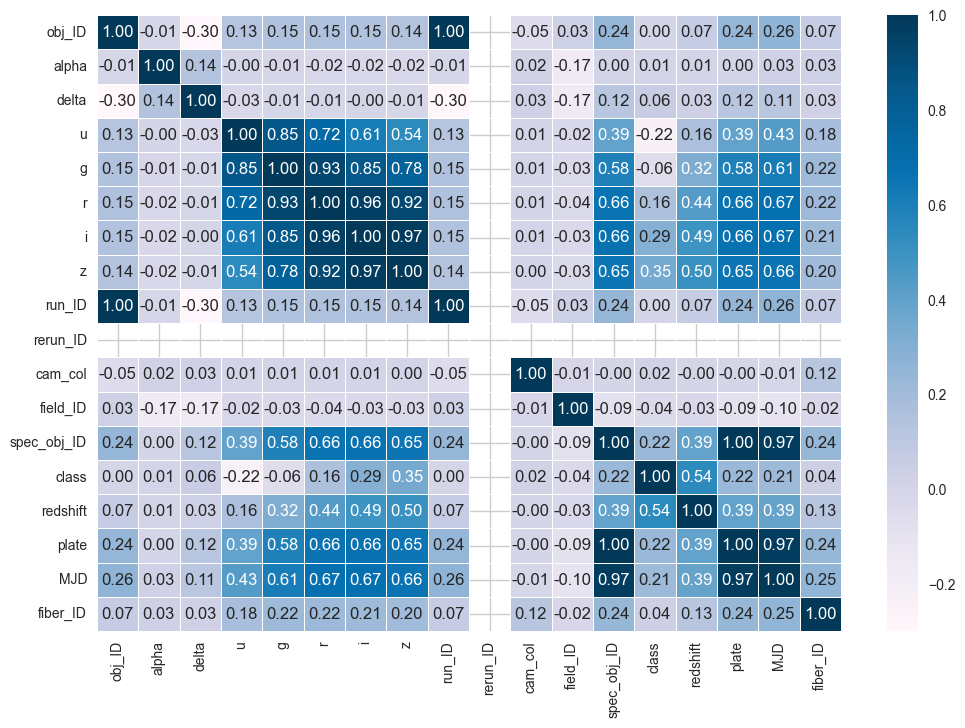

In [100]:
#heatmap
import seaborn as sns
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

In [104]:
#correlation
corr = df.corr()

In [105]:
corr["class"].sort_values()

u             -0.222802
g             -0.058192
field_ID      -0.037542
run_ID         0.000250
obj_ID         0.000252
alpha          0.008187
cam_col        0.017789
fiber_ID       0.037319
delta          0.058947
r              0.160654
MJD            0.214433
spec_obj_ID    0.224718
plate          0.224718
i              0.294075
z              0.349711
redshift       0.541667
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

In [106]:
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)

In [107]:
#imbalanced data
x = df.drop(['class'], axis = 1)
y = df.loc[:,'class'].values

In [108]:
#data scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

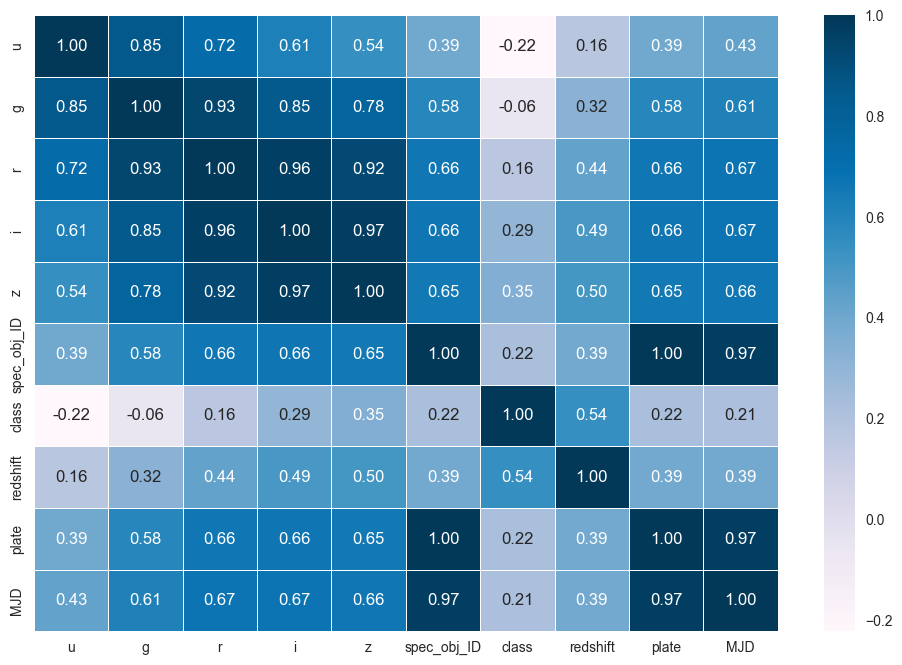

In [109]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

In [112]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42, stratify=y)

In [116]:
x_train

array([[-1.34985649, -1.21601296, -0.96093489, ..., -0.79153942,
         0.12631098,  0.22918313],
       [-1.65125289, -1.78867656, -1.71597931, ..., -0.79175655,
        -0.6631427 , -0.43094323],
       [-1.15142976, -0.59173522, -0.10489599, ...,  1.60406848,
         0.7764493 ,  0.66044363],
       ...,
       [ 0.83604763,  0.51768972,  0.73534256, ..., -0.7927062 ,
         0.7672972 ,  0.64996543],
       [-0.06029901,  0.39786572,  0.87638732, ...,  2.14415385,
         1.74419951,  1.63712181],
       [ 0.97571543,  0.66850787,  0.24451416, ..., -0.2174187 ,
         0.4283304 ,  0.42220253]])

In [132]:
#XGB classifier
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train,y_train)
predicted = xgb_clf.predict(x_test)
score = xgb_clf.score(x_test, y_test)

print('Accuracy : %.3f' % (score))

Accuracy : 0.977


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

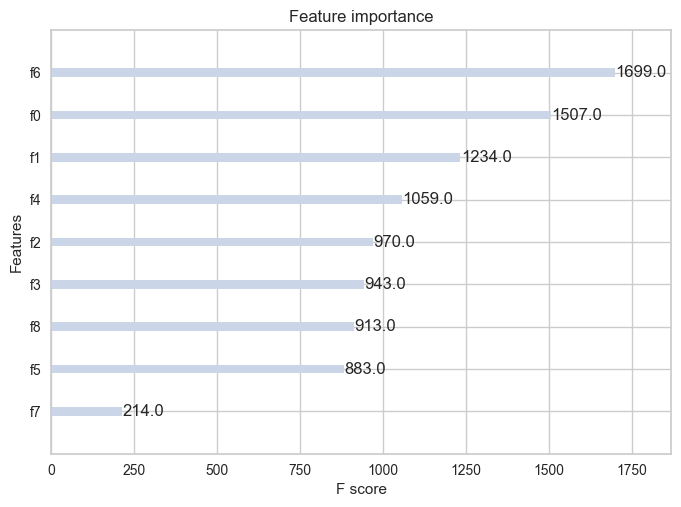

In [120]:
plot_importance(xgb_clf)

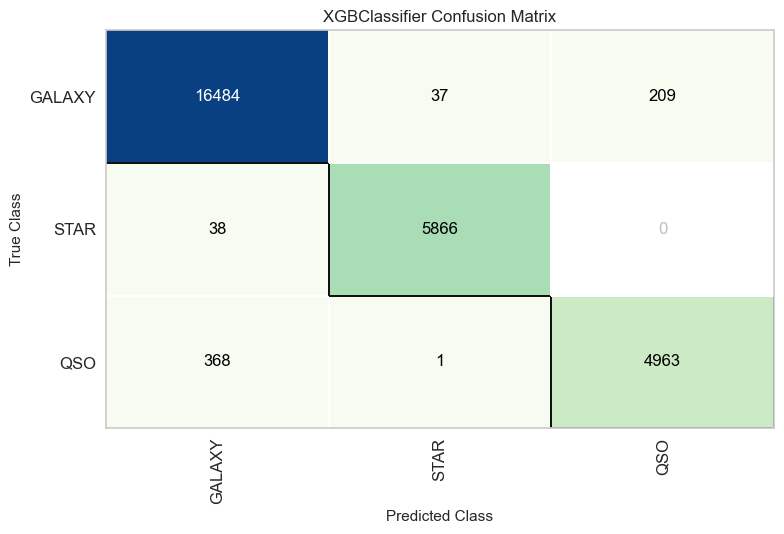

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [122]:
#confusion matrix
xgb_cb = ConfusionMatrix(xgb_clf, classes=classes, cmap='GnBu')

xgb_cb.fit(x_train, y_train)
xgb_cb.score(x_test, y_test)
xgb_cb.show()

In [123]:
#classification report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16730
           1       0.99      0.99      0.99      5904
           2       0.96      0.93      0.94      5332

    accuracy                           0.98     27966
   macro avg       0.98      0.97      0.97     27966
weighted avg       0.98      0.98      0.98     27966



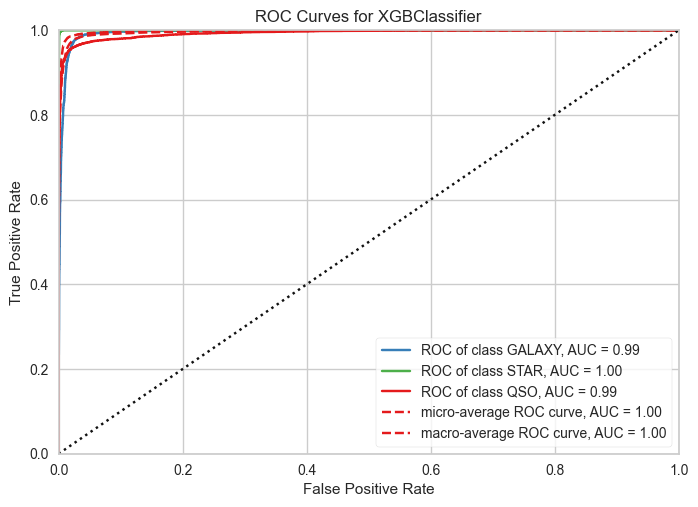

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [124]:
#roc curve
visualizer = ROCAUC(xgb_clf, classes=classes)

set_palette('bold')

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)       
visualizer.show()                       

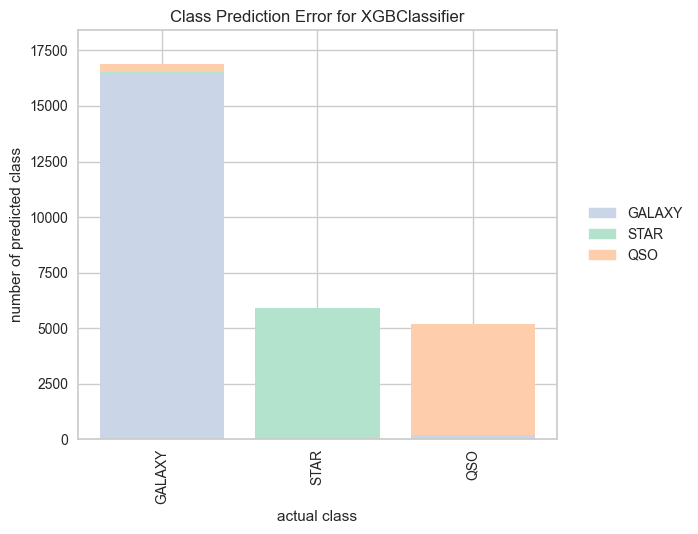

<Axes: title={'center': 'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [125]:
#class prediction error
visualizer = ClassPredictionError(xgb_clf, classes=classes)

set_palette('pastel')

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show()                       

In [126]:
#random forest classifier
r_forest = RandomForestClassifier()
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
# rf_score_ = np.mean(score)

print('Accuracy : %.3f' % (rf_score_))

Accuracy : 0.979


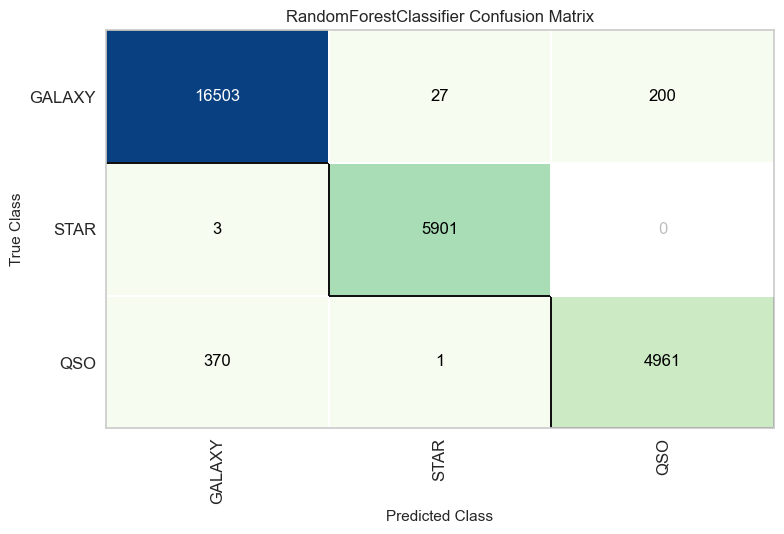

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [127]:
#confusion matrix
r_forest_cm = ConfusionMatrix(r_forest, classes=classes, cmap='GnBu')

r_forest_cm.fit(x_train, y_train)
r_forest_cm.score(x_test, y_test)
r_forest_cm.show()

In [128]:
#classifiaction report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16730
           1       1.00      1.00      1.00      5904
           2       0.96      0.93      0.95      5332

    accuracy                           0.98     27966
   macro avg       0.98      0.97      0.98     27966
weighted avg       0.98      0.98      0.98     27966



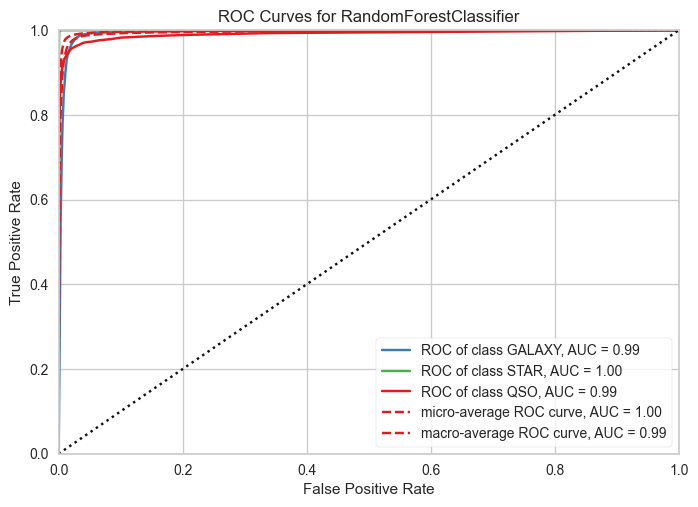

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [129]:
#ROC curve
visualizer = ROCAUC(r_forest, classes=["GALAXY", "STAR", "QSO"])

set_palette('bold')

visualizer.fit(x_train, y_train)       
visualizer.score(x_test, y_test)        
visualizer.show()                      

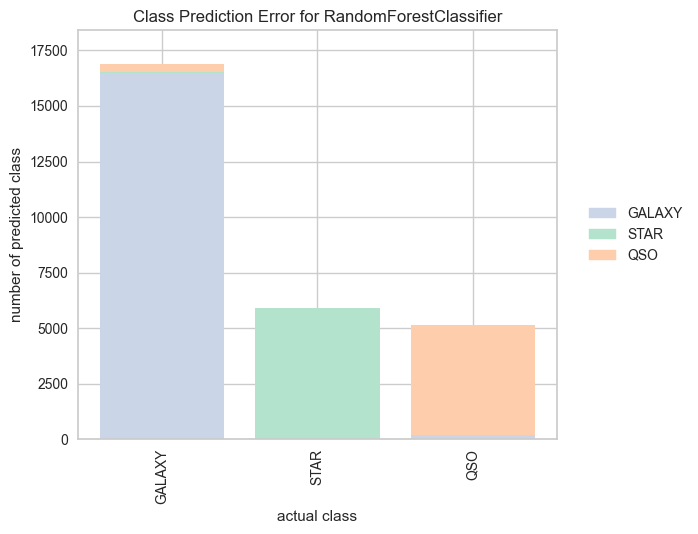

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [130]:
#class prediction
visualizer = ClassPredictionError(r_forest, classes=classes)

set_palette('pastel')

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show()                       